In [ ]:
# default_exp main

In [ ]:
import os
os.chdir('..')
os.getcwd()

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [4]:
#export
# imports
import os
import time
import pickle
import argparse
from functools import partial
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.function import Function
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [5]:
#export
SIZE = 64
NO_TRANSF = [transforms.ToTensor(),
             transforms.Resize(SIZE)]

TRAIN_TRANSF = [transforms.Resize(SIZE),
                #transforms.RandomCrop(64),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.225, 0.226, 0.225],
                                     std=[0.5, 0.5, 0.5])]

VAL_TRANSF = [transforms.Resize(SIZE),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.225, 0.226, 0.225],
                                   std=[0.5, 0.5, 0.5])]

# DATASETS

In [6]:
#export
class FaceClassificationDataset(Dataset):
    """
    """
    def __init__(self,
                 mode,
                 trans_list):

        # Assertions to avoid wrong inputs
        assert mode in ['train', 'val', 'test']
        assert mode == 'test' and n_classes == None or mode != 'test'

        # Directory setup
        data_dirs = {'train': './data/s1/train_data',
                     'val': './data/s1/val_data',
                     'test': './data/s1/test_data'}
        self.data_dir = data_dirs[mode]
        self.mode = mode
        self.trans_list = trans_list

        # Labels
        if (mode in ['train', 'val']):
            #self.labels = np.array([int(d) for d in os.listdir(self.data_dir)])
            self.labels = np.array([int(d) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}') if '.ipynb' not in file])
            
            self.X = np.array([str(file) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}') if '.ipynb' not in file])
            
            #self.labels = self.labels[:50_000]
            #self.X = self.X[:50_000]
        
        elif mode == 'test':
            self.labels = os.listdir(self.data_dir)
            self.labels = np.array([int(f.split('.')[0]) for f in self.labels])
            self.labels.sort(axis=0)

            self.map_files = []
            for l in self.labels:
                temp_ls = [(l, f) for f in \
                    os.listdir(os.path.join(self.data_dir, str(l)))]
                temp_ls = [(t[0], t[1]) for t in temp_ls]
                self.map_files.append(temp_ls)

            self.map_files = [t for sl in self.map_files for t in sl]
            self.labels = [t[0] for t in self.map_files]
            self.X = [t[1] for t in self.map_files]
   
    def __len__(self): 
            return len(self.X)

    def __getitem__(self, idx):
        preprocess = transforms.Compose(self.trans_list)
        
        image_path = os.path.join(self.data_dir, 
                                  str(self.labels[idx]), 
                                  self.X[idx])
        image_tensor = Image.open(image_path)
        image_tensor = preprocess(image_tensor)

        if self.mode == 'test': 
            return image_tensor
        else: 
            return image_tensor, self.labels[idx]

In [7]:
#export
class FaceVerificationDataset(Dataset):
    """
    """
    def __init__(self,
                 mode,
                 trans_list):

        # Assertions to avoid wrong inputs
        assert mode in ['val', 'test']
        assert mode == 'test' and sample == None or mode != 'test'

        # Directory setup
        pairs_dirs = {'val': './data/s2/verification_pairs_val.txt',
                     'test': './data/s2/verification_pairs_test.txt'}
        self.pairs_dir = pairs_dirs[mode]
        self.mode = mode
        self.trans_list = trans_list

        with open(self.pairs_dir) as f:
            self.pairs = [l.rstrip().split() for l in f]
   
    def __len__(self): 
        return len(self.pairs)

    def __getitem__(self, idx):
        preprocess = transforms.Compose(self.trans_list)
        
        image_tensor_0 = Image.open('./data/s2/' + self.pairs[idx][0])
        image_tensor_1 = Image.open('./data/s2/' + self.pairs[idx][1])
        
        image_tensor_0 = preprocess(image_tensor_0)
        image_tensor_1 = preprocess(image_tensor_1)
        
        if self.mode == 'test': 
            return image_tensor_0, image_tensor_1
        else: 
            return image_tensor_0, image_tensor_1, int(self.pairs[idx][2])

## Visualization of original dataset

batch_x.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


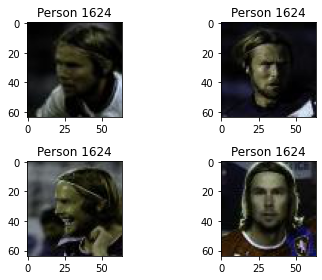

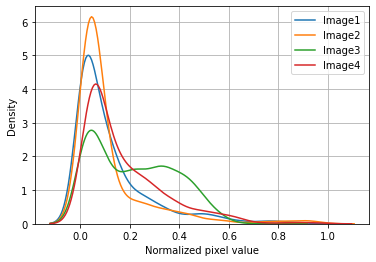

In [8]:
dataset = FaceClassificationDataset(trans_list=NO_TRANSF, mode='train')
dataloader = DataLoader(dataset, shuffle=False, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/original_dataset.png')
plt.show()

pixels = batch_x.reshape(len(batch_x), -1)
sample = np.random.choice(range(pixels.shape[1]), 1000)

ax = sns.kdeplot(data=pixels[0, sample], label='Image1')
sns.kdeplot(data=pixels[1, sample], label='Image2')
sns.kdeplot(data=pixels[2, sample], label='Image3')
sns.kdeplot(data=pixels[3, sample], label='Image4')
plt.grid()
plt.legend()
ax.set(xlabel='Normalized pixel value')
plt.savefig('./results/original_distribution.png')

### Visualization of training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_x.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


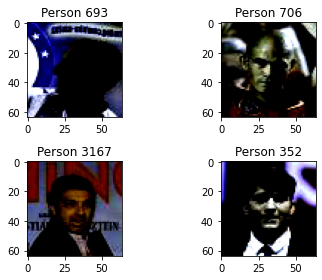

np.mean(pixels[3, sample]) tensor(0.0678)
np.mean(pixels[1, sample]) tensor(-0.0308)
np.mean(pixels[2, sample]) tensor(-0.0027)
np.mean(pixels[3, sample]) tensor(-0.0512)


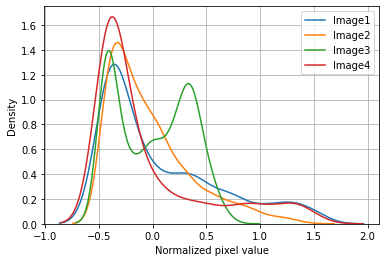

In [9]:
dataset = FaceClassificationDataset(trans_list=TRAIN_TRANSF, mode='val')
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/train_dataset.png')
plt.show()

# Distribution plot
pixels = batch_x.reshape(len(batch_x), -1)
sample = np.random.choice(range(pixels.shape[1]), 1000)

print("np.mean(pixels[3, sample])", pixels[0, sample].mean())
print("np.mean(pixels[1, sample])", pixels[1, sample].mean())
print("np.mean(pixels[2, sample])", pixels[2, sample].mean())
print("np.mean(pixels[3, sample])", pixels[3, sample].mean())

ax = sns.kdeplot(data=pixels[0, sample], label='Image1')
sns.kdeplot(data=pixels[1, sample], label='Image2')
sns.kdeplot(data=pixels[2, sample], label='Image3')
sns.kdeplot(data=pixels[3, sample], label='Image4')
plt.grid()
plt.legend()
ax.set(xlabel='Normalized pixel value')
plt.savefig('./results/train_distribution.png')

## Check verification dataset

batch_x1.shape torch.Size([4, 3, 64, 64])
batch_x2.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


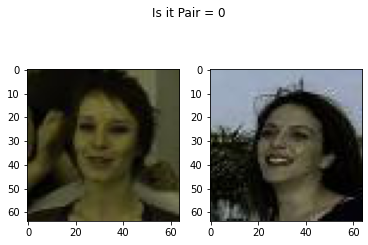

In [10]:
dataset = FaceVerificationDataset(trans_list=NO_TRANSF, mode='val')
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, num_workers=0, drop_last=True)

batch_x1, batch_x2, batch_y = next(iter(dataloader))
print("batch_x1.shape", batch_x1.shape)
print("batch_x2.shape", batch_x2.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(1,2)
axs[0].imshow(batch_x1[0,:,:,:].permute(1, 2, 0))
axs[1].imshow(batch_x2[0,:,:,:].permute(1, 2, 0))
fig.suptitle(f'Is it Pair = {batch_y[0]}')
plt.show()

# CREATE_DATALOADERS FUNCTION

In [11]:
#export
def create_dataloaders(mc):
    num_workers = 8 if torch.cuda.is_available() else 0
    train_dataset = FaceClassificationDataset(trans_list=TRAIN_TRANSF, mode='train')
    clf_dataset   = FaceClassificationDataset(trans_list=VAL_TRANSF, mode='val')
    vrf_dataset   = FaceVerificationDataset(trans_list=VAL_TRANSF, mode='val')

    print(f'n_train: {len(train_dataset)}, n_clf: {len(clf_dataset)}, n_vrf: {len(vrf_dataset)}')

    train_loader = DataLoader(train_dataset, 
                              shuffle=True, 
                              batch_size=mc['batch_size'], 
                              num_workers=num_workers, 
                              pin_memory=torch.cuda.is_available(),
                              drop_last=True)
    
    clf_loader = DataLoader(clf_dataset,
                            shuffle=False, 
                            batch_size=2048,
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    vrf_loader = DataLoader(vrf_dataset, 
                            shuffle=False, 
                            batch_size=2048,
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    assert len(train_loader) > 0
    assert len(clf_loader) > 0
    assert len(vrf_loader) > 0
    
    return train_loader, clf_loader, vrf_loader

# _RESNET
- https://github.com/kuangliu/pytorch-cifar

In [12]:
# export
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class _ResNet(nn.Module):
    def __init__(self, block, num_blocks, input_size=64, num_classes=10):
        super(_ResNet, self).__init__()
        self.in_planes = input_size

        self.conv1 = nn.Conv2d(3, input_size, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(input_size)
        self.layer1 = self._make_layer(block, input_size, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        #self.linear = nn.Linear(512*block.expansion, num_classes)
        self.linear = nn.Linear(512*4, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        embeds = F.avg_pool2d(out, 4)
        embeds = embeds.view(embeds.size(0), -1)
        last = self.linear(embeds)
        return last, embeds

# _CENTERLOSS
- https://github.com/jxgu1016/MNIST_center_loss_pytorch/blob/master/MNIST_with_centerloss.py

In [13]:
# export
class _CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(_CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average

    def forward(self, label, feat):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        # To check the dim of centers and features
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim,feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label, self.centers, batch_size_tensor)
        return loss

class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label, centers, batch_size):
        ctx.save_for_backward(feature, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (feature - centers_batch).pow(2).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        feature, label, centers, batch_size = ctx.saved_tensors
        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        # init every iteration
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())

        counts = counts.scatter_add_(0, label.long(), ones)
        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers/counts.view(-1, 1)
        return - grad_output * diff / batch_size, None, grad_centers / batch_size, None

# RESNET WRAPPER

In [14]:
# export
class ResNet(object):
    def __init__(self, params):
        
        super().__init__()
        self.params = params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Instantiate model
        torch.manual_seed(params['random_seed'])
        np.random.seed(params['random_seed'])
        self.model = _ResNet(block=BasicBlock, 
                             num_blocks=[2, 2, 2, 2],
                             num_classes=params['n_classes'],
                             input_size=params['input_size']).to(self.device)
        self.centerloss = _CenterLoss(num_classes=params['n_classes'], 
                                      feat_dim=512*4).to(self.device)

    def fit(self, train_loader, val_loader, vrf_loader):
        
        params = self.params
        
        #------------------------------------- Optimization --------------------------------------#
        criterion = nn.CrossEntropyLoss()
        optimizer4nn = optim.SGD(self.model.parameters(), lr=params['initial_lr'],
                                 momentum=0.9, weight_decay=params['weight_decay'])
        scheduler = optim.lr_scheduler.StepLR(optimizer4nn, step_size=params['adjust_lr_step'], 
                                              gamma=params['lr_decay'])
        
        if params['with_center_loss']:
            optimizer4center = optim.SGD(self.centerloss.parameters(), lr =params['initial_clr'])
        
        #---------------------------------------- Logging -----------------------------------------#
        step = 0
        epoch = 0
        break_flag = False
        self.best_acc = -1
        updated_optimizer = False
        trajectories = {'step':  [], 'epoch':  [],
                        'train_loss': [], 'train_acc': [],
                        'val_loss': [], 'val_acc': [], 'roc': []}

        print('\n'+'='*43+' Fitting  ResNet '+'='*43)
        while step <= params['iterations']:
            # Train
            epoch += 1
            self.model.train()
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                step+=1
                start = time.time()
                
                if break_flag: # weird epoch breaker
                    continue
                
                #--------------------------------- Forward and Backward ---------------------------------#
                if not params['with_center_loss']:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    optimizer4nn.zero_grad()
                    outputs, embeds = self.model(inputs)

                    loss = criterion(outputs, targets)

                    loss.backward()
                    optimizer4nn.step()

                if params['with_center_loss']:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    optimizer4nn.zero_grad()
                    optimzer4center.zero_grad()
                    outputs, embeds = self.model(inputs)

                    loss = criterion(outputs, targets) + \
                               params['alpha'] * self.centerloss(label=targets, feat=embeds)

                    loss.backward()
                    optimizer4nn.step()
                    optimizer4center.step()
                

                #----------------------------------- Evaluate metrics -----------------------------------#
                if (step % params['display_step']) == 0:
                    train_loss, train_acc = self.evaluate_performance(loader=train_loader, criterion=criterion)
                    #train_loss, train_acc = 0, 0
                    val_loss, val_acc = self.evaluate_performance(loader=val_loader, criterion=criterion)
                    roc, _ = self.evaluate_roc(loader=vrf_loader)
                    
                    display_str = f'step: {step} time: {time.time()-start:03.3f} ** '
                    display_str += f'train_loss: {train_loss:.4f} train_acc {train_acc:.2f} ** '
                    display_str += f'val_loss: {val_loss:.4f} val_acc: {val_acc:.2f} roc {roc:.2f}'
                    print(display_str)
                    
                    trajectories['train_loss'] += [train_loss]
                    trajectories['train_acc']  += [train_acc]
                    trajectories['val_loss']   += [val_loss]
                    trajectories['val_acc']    += [val_acc]
                    trajectories['roc']        += [roc]
                    
                    if val_acc > self.best_acc:
                        self.best_acc = val_acc
                        self.save_weights(path=params['path'])
                        
                if step > params['iterations']:
                    break_flag=True
                
                # Update optimizer learning rate
                scheduler.step()

        #---------------------------------------- Final Logs -----------------------------------------#
        print('\n'+'='*43+' Finished Train '+'='*43)
        self.train_loss   = trajectories['train_loss'][-1]
        self.train_acc    = trajectories['train_acc'][-1]
        self.val_loss     = trajectories['val_loss'][-1]
        self.val_acc      = trajectories['val_acc'][-1]
        self.roc          = trajectories['roc'][-1]
        self.trajectories = trajectories
        
    def evaluate_performance(self, loader, criterion):
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs, _ = self.model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total
        test_loss = test_loss/total
            
        self.model.train()
        return test_loss, acc
    
    def evaluate_roc(self, loader):
        self.model.eval()
                
        embeds0 = []
        embeds1 = []
        targets = []

        with torch.no_grad():
            for batch_idx, (img0, img1, target) in enumerate(loader):
                img0 = img0.to(self.device)
                img1 = img1.to(self.device)
                
                embeds0 += [self.model(img0)[1].cpu().numpy()]
                embeds1 += [self.model(img1)[1].cpu().numpy()]
                targets += [np.expand_dims(target.cpu().numpy(), 1)]
                
        embeds0  = np.vstack(embeds0)
        embeds1  = np.vstack(embeds1)
        targets  = np.vstack(targets)

        sim_score = np.sum((embeds0 - embeds1) ** 2, axis=1, keepdims=True)        
        roc = roc_auc_score(y_true=targets, y_score=sim_score)
        
        self.model.train()
        return roc, sim_score
    
    def predict_labels(self, loader):
        self.model.eval()
        y_hats = []
        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(loader):
                inputs = inputs.to(self.device)
                outputs, _ = self.model(inputs)

                _, predicted = outputs.max(1)
                y_hats += [np.expand_dims(predicted.cpu().numpy(), 1)]
                
        y_hats = np.vstack(y_hats)
        self.model.train()
        return y_hats
    
    def predict_similarity(self, loader):
        self.model.eval()
                
        embeds0 = []
        embeds1 = []
        with torch.no_grad():
            for batch_idx, (img0, img1, target) in enumerate(loader):
                img0 = img0.to(self.device)
                img1 = img1.to(self.device)
                
                embeds0 += [self.model(img0)[1].cpu().numpy()]
                embeds1 += [self.model(img1)[1].cpu().numpy()]
                
        embeds0  = np.vstack(embeds0)
        embeds1  = np.vstack(embeds1)

        sim_score = np.sum((embeds0 - embeds1) ** 2, axis=1, keepdims=True)                
        self.model.train()
        return sim_score
    
    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)    

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path,
                                   map_location=torch.device(self.device)))
        self.model.eval()

# HYPERPARAMETER OPTIMIZATION

In [15]:
#export
def fit_and_log(mc, verbose, trials=None):
    start_time = time.time()    
    
    train_loader, clf_loader, vrf_loader = create_dataloaders(mc)

    print('='*50)
    print(pd.Series(mc))
    print('='*50+'\n')
        
    model = ResNet(params=mc)
        
    model.fit(train_loader=train_loader, 
              val_loader=clf_loader,
              vrf_loader=vrf_loader)
    
    results = {#----------------- Hyperopt -----------------#
               'loss':       (100.-model.best_acc),
               'status': STATUS_OK,
               'mc': mc,
               'path': mc['path'],
               #------------------- Logs -------------------#
               'train_loss': model.train_loss,
               'train_acc':  model.train_acc,
               'val_loss':   model.val_loss,
               'val_acc':    model.val_acc,
               'val_acc':    model.roc,
               'run_time': time.time()-start_time,
               'trajectories': model.trajectories} 
    return results

# MAIN

In [16]:
#export
def main(args, max_evals):
    # Hyperparameters space
    model_path = f"./checkpoint/{args.experiment_id}_ckpt.pth"
    trials_path = f"./results/{args.experiment_id}_trials.p"
    display_step = args.iterations//100 if args.iterations > 1000 else 10 # relative display steps
    space = {#------------------------------------- Architecture -------------------------------------#
             'experiment_id': hp.choice(label='experiment_id', options=[args.experiment_id]),
             'input_size': hp.choice(label='input_size', options=[SIZE]),
             'n_classes': hp.choice(label='n_classes', options=[4_000]),
             #------------------------------ Optimization Regularization -----------------------------#
             'iterations': hp.choice(label='iterations', options=[args.iterations]),
             'display_step': scope.int(hp.choice(label='display_step', options=[display_step])),
             'batch_size': scope.int(hp.choice(label='batch_size', options=[128])),
             #'initial_lr': hp.loguniform(label='lr', low=np.log(5e-3), high=np.log(0.1)),
             'initial_lr': scope.float(hp.choice(label='initial_lr', options=[0.1])),
             'lr_decay': scope.float(hp.choice(label='lr_decay', options=[0.5])),
             'adjust_lr_step': hp.choice(label='adjust_lr_step', options=[300_000//3]),
             'weight_decay': hp.choice(label='weight_decay', options=[5e-4]),
             'with_center_loss': hp.choice(label='with_center_loss', options=[args.with_center_loss]),
             'initial_clr': hp.choice(label='initial_clr', options=[0.01, 0.05, 0.1, 0.5]),
             'alpha': hp.choice(label='alpha', options=[0.1, 0.01]),
             #'display_step': scope.int(hp.choice(label='eval_epochs', options=[3_000])),
             #--------------------------------------   Others   --------------------------------------#
             'path': hp.choice(label='path', options=[model_path]),
             'trials_path': hp.choice(label='trials_path', options=[trials_path]),
             'random_seed': scope.int(hp.quniform('random_seed', 1, 10, 1))}

    # Hyperparameters search
    trials = Trials()
    fmin_objective = partial(fit_and_log, trials=trials, verbose=True)
    best_model = fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    
    # Save output
    with open(trials_path, "wb") as f:
        pickle.dump(trials, f)

In [17]:
# export
def parse_args():
    desc = "Classification/anomaly detection shared trend metric experiment"
    parser = argparse.ArgumentParser(description=desc)
    parser.add_argument('--iterations', required=True, type=int, help='Iterations to train network')
    parser.add_argument('--with_center_loss', required=True, type=bool, help='Wether center loss is used')
    parser.add_argument('--experiment_id', required=True, type=str, help='string to identify experiment')
    return parser.parse_args()

In [18]:
os.getcwd()
# os.chdir('..')

'/home/ubuntu/hw2p2'

In [19]:
#export
if __name__ == "__main__":
    #args = parse_args()
    args = pd.Series({'iterations': 20, 
                      'with_center_loss': False,
                      'experiment_id': 'security'})
    main(args, max_evals=1)

n_train: 380638, n_clf: 8000, n_vrf: 8805            
adjust_lr_step                              100000   
alpha                                         0.01
batch_size                                     128
display_step                                    10
experiment_id                             security
initial_clr                                    0.5
initial_lr                                     0.1
input_size                                      64
iterations                                      20
lr_decay                                       0.5
n_classes                                     4000
path                ./checkpoint/security_ckpt.pth
random_seed                                     10
trials_path            ./results/security_trials.p
weight_decay                                0.0005
with_center_loss                             False
dtype: object

                                                     
=========================================== Fitting  ResNe

KeyboardInterrupt: 

# KAGGLE SUBMISSION

In [ ]:
# export
def parse_trials(trials):
    # Initialize
    trials_dict = {'tid': [],
                   'loss': [],
                   'trajectories': [],
                   'mc': []}
    for tidx in range(len(trials)):
        # Main
        trials_dict['tid']  += [trials.trials[tidx]['tid']]
        trials_dict['loss'] += [trials.trials[tidx]['result']['loss']]
        trials_dict['trajectories'] += [trials.trials[tidx]['result']['trajectories']]

        # Model Configs
        mc = trials.trials[tidx]['result']['mc']
        trials_dict['mc'] += [mc]
    
    trials_df = pd.DataFrame(trials_dict)
    return trials_df

In [ ]:
# read trials file
trials_path = f"./results/security_trials.p"
trials_df = parse_trials(pickle.load(open(trials_path, 'rb')))
trials_df

In [ ]:
# load best config and load trained weights
best_mc = trials_df.loc[trials_df.loss.idxmin()]['mc']
model = ResNet(params=best_mc)
model.load_weights(path=best_mc['path'])

In [ ]:
# get data_loaders and produce kaggle submission
_, clf_loader, vrf_loader = create_dataloaders(mc=best_mc)
y_hats = model.predict_labels(loader=clf_loader)
sim_scores = model.predict_similarity(loader=vrf_loader)
print("y_hats.shape", y_hats.shape)
print("sim_scores.shape", sim_scores.shape)